In [1]:
# !pip install inltk
!pip install fasttext
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.hi.zip
!unzip 'wiki.hi.zip'

  Using cached fasttext-0.9.2.tar.gz (68 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3143565 sha256=408039afe54f8506fecf93be814b706a222949596017f14232ce6272dc79f86b
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext
--2022-04-30 07:07:26--  https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.hi.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2779916118 (2.6G) [application/zip]
Saving to: ‘wiki.hi.zip’

wiki.hi.zip         100%[===================>]   2.59G  3.34MB/s    in 12m 38s 

2022-04-30 07:20:05 (3.50 MB/s) - ‘wiki.hi.zip’ saved [2779916118/2779916118]

Archive:  wiki.hi.zip
  inflating: wiki.hi.vec             
  inflating: wiki.hi.bin   

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses

In [4]:
# from inltk.inltk import get_embedding_vectors
# from inltk.inltk import setup
# setup("hi")

### Dataset reading and annotations

In [5]:
url = "https://raw.githubusercontent.com/PrynkaSxna/dataset/main/Bhaav-Dataset.csv"
dataset = pd.read_csv(url)

In [6]:
dataset

,Sentences,Annotation
0,रमजान के पूरे तीस रोजों के बाद ईद आयी है,1
1,"कितना मनोहर, कितना सुहावना प्रभाव है",1
2,"वृक्षों पर अजीब हरियाली है, खेतों में कुछ अजीब...",1
3,"आज का सूर्य देखो, कितना प्यारा, कितना शीतल है,...",1
4,गाँव में कितनी हलचल है,1
...,...,...
20299,फिर यहाँ सर्दी हो जाती है,4
20300,दिन-भर मैं यह देखती रहती हूँ कि धूप का टुकड़ा क...,4
20301,"पार्क का कोई ऐसा कोना नहीं, जहाँ मैं घड़ी-आधा घ...",4
20302,लेकिन यह बेंच मुझे सबसे अच्छी लगती है,1


In [7]:
dataset['Annotation'].value_counts()

4    11697
2     3168
1     2463
3     1512
0     1464
Name: Annotation, dtype: int64

In [8]:
dataset['Emotion'] = np.where(
    dataset['Annotation'] == 0, 'Anger', np.where(
        dataset['Annotation'] == 1, 'Joy', np.where(
            dataset['Annotation'] == 2, 'Sad', np.where(
                dataset['Annotation'] == 3, 'Suspense', 'Neutral'))))

In [9]:
dataset['Emotion'].value_counts()

Neutral     11697
Sad          3168
Joy          2463
Suspense     1512
Anger        1464
Name: Emotion, dtype: int64

### Convert to TF Dataset and Train/Test Split

In [10]:
full_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(dataset['Sentences'].values, tf.string),
            tf.cast(dataset['Annotation'].values, tf.int32)
        )
    )
)

In [11]:
train_size = int(dataset.shape[0]*0.8)

In [12]:
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)

In [13]:
batch_size = 16

In [14]:
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

### Preprocessing
* Tokenisation
* Punctuation Removal
* Embed words to ints

In [15]:
max_features = 10000
sequence_length = 100

vectorize_layer = layers.TextVectorization(
    standardize="strip_punctuation",
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [16]:
train_text = train_dataset.map(lambda x, y: x)

In [17]:
vectorize_layer.adapt(train_text)

In [18]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [19]:
text_batch, label_batch = next(iter(train_dataset))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", first_label)
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'\xe0\xa4\xb0\xe0\xa4\xae\xe0\xa4\x9c\xe0\xa4\xbe\xe0\xa4\xa8 \xe0\xa4\x95\xe0\xa5\x87 \xe0\xa4\xaa\xe0\xa5\x82\xe0\xa4\xb0\xe0\xa5\x87 \xe0\xa4\xa4\xe0\xa5\x80\xe0\xa4\xb8 \xe0\xa4\xb0\xe0\xa5\x8b\xe0\xa4\x9c\xe0\xa5\x8b\xe0\xa4\x82 \xe0\xa4\x95\xe0\xa5\x87 \xe0\xa4\xac\xe0\xa4\xbe\xe0\xa4\xa6 \xe0\xa4\x88\xe0\xa4\xa6 \xe0\xa4\x86\xe0\xa4\xaf\xe0\xa5\x80 \xe0\xa4\xb9\xe0\xa5\x88', shape=(), dtype=string)
Label tf.Tensor(1, shape=(), dtype=int32)
Vectorized review (<tf.Tensor: shape=(1, 100), dtype=int64, numpy=
array([[   1,    2,  839, 2833,    1,    2,   78, 2223,  320,    7,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0, 

In [20]:
train_ds = train_dataset.map(vectorize_text)
val_ds = test_dataset.map(vectorize_text)

In [21]:
vocab = vectorize_layer.get_vocabulary()
word_index = dict(zip(vocab, range(len(vocab))))

In [22]:
import fasttext
import fasttext.util
ft = fasttext.load_model('wiki.hi.bin')
word = "नृत्य"
print("Embedding Shape is {}".format(ft.get_word_vector(word).shape))
print("Nearest Neighbors to {} are:".format(word))
ft.get_nearest_neighbors(word) 

Embedding Shape is (300,)
Nearest Neighbors to नृत्य are:


[(0.8913929462432861, 'नृत्य।'),
 (0.8440190553665161, 'नृत्यगान'),
 (0.8374733924865723, 'नृत्यगीत'),
 (0.8336297869682312, 'नृत्यों'),
 (0.8265783190727234, 'नृत्यरत'),
 (0.7971948385238647, 'नृत्यकला'),
 (0.7879464626312256, 'नृत्त'),
 (0.7682990431785583, 'नृतक'),
 (0.7622954845428467, 'नृत्यरचना'),
 (0.7602956295013428, 'नृत्यग्राम')]

In [23]:
embedding_dim = 300

# Prepare embedding matrix
hits = 0
misses = 0
embedding_matrix = np.zeros((max_features, embedding_dim))
for word, i in word_index.items():
    embedding_vector = ft.get_word_vector(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 10000 words (0 misses)


### Model definition

In [24]:
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), trainable=False),
  layers.Dropout(0.25),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.25),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(64, activation='relu'),
  layers.Dense(5, activation='softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         3000000   
                                                                 
 dropout (Dropout)           (None, None, 300)         0         
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense (Dense)               (None, 128)               38528     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                        

In [25]:
model.compile(loss=losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=tf.metrics.SparseCategoricalAccuracy())

In [26]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
1016/1016 [==============================] - 14s 8ms/step - loss: 1.2719 - sparse_categorical_accuracy: 0.5449 - val_loss: 1.1022 - val_sparse_categorical_accuracy: 0.6646
Epoch 2/10
1016/1016 [==============================] - 5s 5ms/step - loss: 1.2470 - sparse_categorical_accuracy: 0.5474 - val_loss: 1.1008 - val_sparse_categorical_accuracy: 0.6646
Epoch 3/10
1016/1016 [==============================] - 5s 5ms/step - loss: 1.2309 - sparse_categorical_accuracy: 0.5536 - val_loss: 1.0908 - val_sparse_categorical_accuracy: 0.6646
Epoch 4/10
1016/1016 [==============================] - 5s 5ms/step - loss: 1.2218 - sparse_categorical_accuracy: 0.5538 - val_loss: 1.0807 - val_sparse_categorical_accuracy: 0.6646
Epoch 5/10
1016/1016 [==============================] - 6s 6ms/step - loss: 1.2138 - sparse_categorical_accuracy: 0.5537 - val_loss: 1.0797 - val_sparse_categorical_accuracy: 0.6646
Epoch 6/10
1016/1016 [==============================] - 5s 5ms/step - loss: 1.2063 - spar

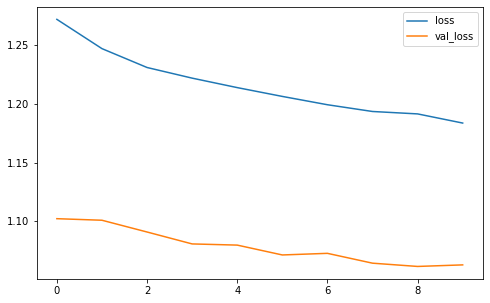

In [27]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize=(8,5))

In [28]:
val_softmax = model.predict(val_ds)

In [29]:
val_labels = np.argmax(val_softmax, axis=1)

In [30]:
val_pd = dataset[train_size:]

In [31]:
val_pd['pred_labels'] = val_labels
print(classification_report(val_pd['Annotation'], val_pd['pred_labels']))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       183
           1       0.00      0.00      0.00       416
           2       0.00      0.00      0.00       625
           3       0.00      0.00      0.00       138
           4       0.66      1.00      0.80      2699

    accuracy                           0.66      4061
   macro avg       0.13      0.20      0.16      4061
weighted avg       0.44      0.66      0.53      4061



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [32]:
# val_pd

In [33]:
# val_pd['pred_labels'].value_counts()

In [34]:
# val_pd['Annotation'].value_counts()

### LSTM

In [35]:
model = tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dim, mask_zero=True, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), trainable=False),
    tf.keras.layers.LSTM(64),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(5, activation='softmax')
])

In [36]:
model.compile(loss=losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=tf.metrics.SparseCategoricalAccuracy())

In [37]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
1016/1016 [==============================] - 24s 16ms/step - loss: 1.3040 - sparse_categorical_accuracy: 0.5473 - val_loss: 1.0959 - val_sparse_categorical_accuracy: 0.6646
Epoch 2/10
1016/1016 [==============================] - 14s 14ms/step - loss: 1.2723 - sparse_categorical_accuracy: 0.5524 - val_loss: 1.0892 - val_sparse_categorical_accuracy: 0.6646
Epoch 3/10
1016/1016 [==============================] - 16s 16ms/step - loss: 1.2459 - sparse_categorical_accuracy: 0.5533 - val_loss: 1.0868 - val_sparse_categorical_accuracy: 0.6646
Epoch 4/10
1016/1016 [==============================] - 15s 14ms/step - loss: 1.2234 - sparse_categorical_accuracy: 0.5521 - val_loss: 1.0743 - val_sparse_categorical_accuracy: 0.6646
Epoch 5/10
1016/1016 [==============================] - 14s 14ms/step - loss: 1.2071 - sparse_categorical_accuracy: 0.5527 - val_loss: 1.0694 - val_sparse_categorical_accuracy: 0.6646
Epoch 6/10
1016/1016 [==============================] - 15s 14ms/step - loss: 1.

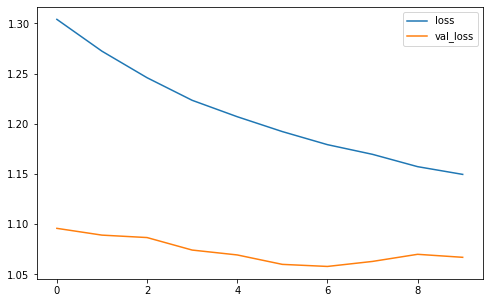

In [38]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize=(8,5))

In [39]:
val_softmax = model.predict(val_ds)
val_labels = np.argmax(val_softmax, axis=1)

val_pd['lstm_pred'] = val_labels

print(classification_report(val_pd['Annotation'], val_pd['lstm_pred']))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       183
           1       0.33      0.00      0.01       416
           2       0.40      0.01      0.01       625
           3       0.00      0.00      0.00       138
           4       0.67      1.00      0.80      2699

    accuracy                           0.66      4061
   macro avg       0.28      0.20      0.16      4061
weighted avg       0.54      0.66      0.53      4061



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,